In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker
import numpy as np
import sklearn.model_selection as ms

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
from sklearn import svm

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

# Start Here

After creating the .csv files in the format needed, the bowl prediction code begins here.

In [2]:
games14 = pd.read_csv('games/games14.csv')
games15 = pd.read_csv('games/games15.csv')
games16 = pd.read_csv('games/games16.csv')
games17 = pd.read_csv('games/games17.csv')
games18 = pd.read_csv('games/games18.csv')
games19 = pd.read_csv('games/games19.csv')
games20 = pd.read_csv('games/games20.csv')
games21 = pd.read_csv('games/games21.csv')
games22 = pd.read_csv('games/games22.csv')

In [3]:
bowls14 = pd.read_csv('Bowl_Games/bowls_14.csv')
bowls15 = pd.read_csv('Bowl_Games/bowls_15.csv')
bowls16 = pd.read_csv('Bowl_Games/bowls_16.csv')
bowls17 = pd.read_csv('Bowl_Games/bowls_17.csv')
bowls18 = pd.read_csv('Bowl_Games/bowls_18.csv')
bowls19 = pd.read_csv('Bowl_Games/bowls_19.csv')
bowls20 = pd.read_csv('Bowl_Games/bowls_20.csv')
bowls21 = pd.read_csv('Bowl_Games/bowls_21.csv')


In [4]:
games14['Year'] = 2014
games15['Year'] = 2015
games16['Year'] = 2016
games17['Year'] = 2017
games18['Year'] = 2018
games19['Year'] = 2019
games20['Year'] = 2020
games21['Year'] = 2021
games22['Year'] = 2022

bowls14['Year'] = 2014
bowls15['Year'] = 2015
bowls16['Year'] = 2016
bowls17['Year'] = 2017
bowls18['Year'] = 2018
bowls19['Year'] = 2019
bowls20['Year'] = 2020
bowls21['Year'] = 2021



# Games Into One Row

In [5]:
games_list = [games14,games15,games16,games17,games18,games19,games20,games21,games22]
dict = {'H_offense':'home_team',
        'H_defense':'away_team',
        'H_game_id': 'game_id',
        'H_Off. Conf': 'home_conf',
        'H_Def. Conf': 'away_conf',
        'H_Win':'home_win',
        'H_offense_score':'H_score',
        'H_defense_score': 'A_score',
        'H_score_diff':'H_score_diff',
        'H_Def SoS':'H_SoS',
        'A_Def SoS':'A_SoS'  
       }
comb_games = []
for df in games_list:
    temp1 = df[df['LocOff'] == 1].add_prefix('H_')
    temp2 = df[df['LocOff'] == -1].add_prefix('A_')
    temp3 = temp1.join(temp2.set_index('A_game_id'), on='H_game_id', how='left')
    
    temp3 = temp3.drop(['H_Unnamed: 0','H_LocOff','H_LocDef','H_Year','A_Unnamed: 0','A_offense', 'A_defense', 'A_LocOff', 'A_LocDef', 'A_Off. Conf', 'A_Def. Conf','A_offense_score', 'A_defense_score','A_Win', 'A_score_diff'], axis=1)
    temp3.rename(columns=dict,inplace=True)
    comb_games.append(temp3)

for i, df in enumerate(comb_games):
    globals()[f"games{i+14}"] = df

In [6]:
games14.columns

Index(['home_team', 'away_team', 'game_id', 'home_conf', 'away_conf',
       'H_Plays', 'H_Rush Atts', 'H_Rush Yards', 'H_Pass Atts', 'H_Pass Yards',
       'H_Off. Drives', 'H_Turnover', 'H_Field Goal Made',
       'H_Field Goal Attempt', 'H_score', 'A_score', 'H_PPD', 'home_win',
       'H_score_diff', 'H_OT', 'H_SoS', 'A_Plays', 'A_Rush Atts',
       'A_Rush Yards', 'A_Pass Atts', 'A_Pass Yards', 'A_Off. Drives',
       'A_Turnover', 'A_Field Goal Made', 'A_Field Goal Attempt', 'A_PPD',
       'A_OT', 'A_SoS', 'A_Year'],
      dtype='object')

# Season Means (For Bowl Prediction)

In [7]:
def home_calcs(x):
    names = {'Plays': x['H_Plays'].sum(),
             'Rush Atts': x['H_Rush Atts'].sum(),
             'Rush Yards': x['H_Rush Yards'].sum(),
             'Pass Atts': x['H_Pass Atts'].sum(),
             'Pass Yards': x['H_Pass Yards'].sum(),
             'Off. Drives': x['H_Off. Drives'].sum(),
             'Turnover': x['H_Turnover'].sum(),
             'Field Goal Made': x['H_Field Goal Made'].sum(),
             'Field Goal Attempt': x['H_Field Goal Attempt'].sum(),
             'PPD': x['H_PPD'].sum(),
             'SoS': x['H_SoS'].sum(),
             'OT': x['H_OT'].sum()
            }
    return pd.Series(names)

def away_calcs(x):
    names = {'Plays': x['A_Plays'].sum(),
             'Rush Atts': x['A_Rush Atts'].sum(),
             'Rush Yards': x['A_Rush Yards'].sum(), 
             'Pass Atts': x['A_Pass Atts'].sum(), 
             'Pass Yards': x['A_Pass Yards'].sum(), 
             'Off. Drives': x['A_Off. Drives'].sum(),
             'Turnover': x['A_Turnover'].sum(),
             'Field Goal Made': x['A_Field Goal Made'].sum(),
             'Field Goal Attempt': x['A_Field Goal Attempt'].sum(),
             'PPD': x['A_PPD'].sum(),
             'SoS': x['A_SoS'].sum(),
             'OT': x['A_OT'].sum()
            }
    return pd.Series(names)

In [8]:

home14 =  games14.groupby(['home_team'], sort = False).apply(home_calcs)
home15 =  games15.groupby('home_team', sort = False).apply(home_calcs)
home16 =  games16.groupby('home_team', sort = False).apply(home_calcs)
home17 =  games17.groupby('home_team', sort = False).apply(home_calcs)
home18 =  games18.groupby('home_team', sort = False).apply(home_calcs)
home19 =  games19.groupby('home_team', sort = False).apply(home_calcs)
home20 =  games20.groupby('home_team', sort = False).apply(home_calcs)
home21 =  games21.groupby('home_team', sort = False).apply(home_calcs)
home22 =  games22.groupby('home_team', sort = False).apply(home_calcs)

In [9]:
away14 =  games14.groupby(['away_team'], sort = False).apply(away_calcs)
away15 =  games15.groupby('away_team', sort = False).apply(away_calcs)
away16 =  games16.groupby('away_team', sort = False).apply(away_calcs)
away17 =  games17.groupby('away_team', sort = False).apply(away_calcs)
away18 =  games18.groupby('away_team', sort = False).apply(away_calcs)
away19 =  games19.groupby('away_team', sort = False).apply(away_calcs)
away20 =  games20.groupby('away_team', sort = False).apply(away_calcs)
away21 =  games21.groupby('away_team', sort = False).apply(away_calcs)
away22 =  games22.groupby('away_team', sort = False).apply(away_calcs)

In [10]:

season14 = home14.add(away14, fill_value=0)/12
season15 = home15.add(away15, fill_value=0)/12
season16 = home16.add(away16, fill_value=0)/12
season17 = home17.add(away17, fill_value=0)/12
season18 = home18.add(away18, fill_value=0)/12
season19 = home19.add(away19, fill_value=0)/12
season20 = home20.add(away20, fill_value=0)/12
season21 = home21.add(away21, fill_value=0)/12
season22 = home22.add(away22, fill_value=0)/12


In [11]:
bowls22 = pd.DataFrame({'home_team':['TCU','Georgia','Kansas State','Clemson','Texas','Oklahoma','Georgia'],'away_team':['Michigan','Ohio State','Alabama','Tennessee','Washington','Florida State','Michigan'],'home_conference':['Big 12','SEC','Big 12','ACC','Big 12','Big 12','SEC'],'away_conference':['Big Ten','Big Ten','SEC','SEC','Pac-12','ACC','Big Ten']})

In [12]:
bowls22['Year'] = 2022

In [13]:
bowls14 = bowls14.merge(season14, left_on='home_team', right_index=True, how='left')
bowls15 = bowls15.merge(season15, left_on='home_team', right_index=True, how='left')
bowls16 = bowls16.merge(season16, left_on='home_team', right_index=True, how='left')
bowls17 = bowls17.merge(season17, left_on='home_team', right_index=True, how='left')
bowls18 = bowls18.merge(season18, left_on='home_team', right_index=True, how='left')
bowls19 = bowls19.merge(season19, left_on='home_team', right_index=True, how='left')
bowls20 = bowls20.merge(season20, left_on='home_team', right_index=True, how='left')
bowls21 = bowls21.merge(season21, left_on='home_team', right_index=True, how='left')
bowls22 = bowls22.merge(season22, left_on='home_team', right_index=True, how='left')


In [14]:
bowls14 = bowls14.merge(season14, left_on='away_team', right_index=True, how='left')
bowls15 = bowls15.merge(season15, left_on='away_team', right_index=True, how='left')
bowls16 = bowls16.merge(season16, left_on='away_team', right_index=True, how='left')
bowls17 = bowls17.merge(season17, left_on='away_team', right_index=True, how='left')
bowls18 = bowls18.merge(season18, left_on='away_team', right_index=True, how='left')
bowls19 = bowls19.merge(season19, left_on='away_team', right_index=True, how='left')
bowls20 = bowls20.merge(season20, left_on='away_team', right_index=True, how='left')
bowls21 = bowls21.merge(season21, left_on='away_team', right_index=True, how='left')
bowls22 = bowls22.merge(season22, left_on='away_team', right_index=True, how='left')



In [15]:
dict = {'home_conference':'home_conf','away_conference':'away_conf','home_points':'H_score','away_points':'A_score','Plays_x':'H_Plays', 'Rush Atts_x':'H_Rush Atts', 'Rush Yards_x':'H_Rush Yards', 'Pass Atts_x':'H_Pass Atts', 'Pass Yards_x':'H_Pass Yards',
       'Off. Drives_x':'H_Off. Drives', 'Turnover_x':'H_Turnover', 'Field Goal Made_x':'H_Field Goal Made',
       'Field Goal Attempt_x':'H_Field Goal Attempts', 'PPD_x':'H_PPD', 'SoS_x':'H_SoS','OT_x':'H_OT', 'Plays_y':'A_Plays', 'Rush Atts_y':'A_Rush Atts',
       'Rush Yards_y':'A_Rush Yards', 'Pass Atts_y':'A_Pass Atts', 'Pass Yards_y':'A_Pass Yards', 'Off. Drives_y':'A_Off. Drives',
       'Turnover_y':'A_Turnover', 'Field Goal Made_y':'A_Field Goal Made', 'Field Goal Attempt_y':'A_Field Goal Attempt', 'PPD_y':'A_PPD',
       'SoS_y':'A_SoS','OT_y':'A_OT','Year':'A_Year'}

bowls14.rename(columns=dict, inplace=True)
bowls15.rename(columns=dict, inplace=True)
bowls16.rename(columns=dict, inplace=True)
bowls17.rename(columns=dict, inplace=True)
bowls18.rename(columns=dict, inplace=True)
bowls19.rename(columns=dict, inplace=True)
bowls20.rename(columns=dict, inplace=True)
bowls21.rename(columns=dict, inplace=True)
bowls22.rename(columns=dict, inplace = True)


In [16]:
games_list = [games14,games15,games16,games17,games18,games19,games20,games21,games22]
bowls_list = [bowls14,bowls15,bowls16,bowls17,bowls18,bowls19,bowls20,bowls21,bowls22]

# Create a dictionary of replacement values
games_conf_dict = {"['SEC']": 1,
                   "['Big Ten']": 2,
                   "['Big 12']": 3,
                   "['ACC']":4,
                   "['Pac-12']":5,
                   "['FBS Independents']":6,
                   "['American Athletic']":7,
                   "['Sun Belt']":8,
                   "['Conference USA']":9,
                   "['Mountain West']":10,
                   "['Mid-American']":11,
                   "['Ivy']":12,
                   "['MVFC']":13,
                   "['Big Sky']": 14,
                   "['CAA']":15,
                   "['SWAC']":16,
                   "['Southern']": 17,
                   "['Big South']": 18,
                   "['Southland']": 19,
                   "['OVC']": 20,
                   "['Patriot']": 21,
                   "['NEC']":22,
                   "['Pioneer']":23,
                   "['MEAC']":24,
                   "['Western Athletic']":16,
                   "['Lone Star']":25,
                   "['AWC']":26
                   
                   
            }

# Create a dictionary of replacement values
bowls_conf_dict = {'SEC': 1,
             'Big Ten': 2,
             'Big 12': 3,
             'ACC':4,
             'Pac-12':5,
             'FBS Independents':6,
             'American Athletic':7,
             'Sun Belt':8,
             'Conference USA':9,
             'Mountain West':10,
             'Mid-American':11,
             'Ivy':12
            }

# Loop through the list of dataframes
for df in games_list:
    # Replace the values in the specified column
    df['home_conf'] = df['home_conf'].replace(games_conf_dict)
    df['away_conf'] = df['away_conf'].replace(games_conf_dict)
    df.loc[df['home_conf'].apply(lambda x: isinstance(x, str)), 'home_conf'] = 30
    df.loc[df['away_conf'].apply(lambda x: isinstance(x, str)), 'away_conf'] = 30
    
    
for df in bowls_list:
    df['home_conf'] = df['home_conf'].replace(bowls_conf_dict)
    df['away_conf'] = df['away_conf'].replace(bowls_conf_dict)
    

In [17]:
games14.columns

Index(['home_team', 'away_team', 'game_id', 'home_conf', 'away_conf',
       'H_Plays', 'H_Rush Atts', 'H_Rush Yards', 'H_Pass Atts', 'H_Pass Yards',
       'H_Off. Drives', 'H_Turnover', 'H_Field Goal Made',
       'H_Field Goal Attempt', 'H_score', 'A_score', 'H_PPD', 'home_win',
       'H_score_diff', 'H_OT', 'H_SoS', 'A_Plays', 'A_Rush Atts',
       'A_Rush Yards', 'A_Pass Atts', 'A_Pass Yards', 'A_Off. Drives',
       'A_Turnover', 'A_Field Goal Made', 'A_Field Goal Attempt', 'A_PPD',
       'A_OT', 'A_SoS', 'A_Year'],
      dtype='object')

# Splitting Regular Season Train, Test Sets

In [18]:
y_14 = games14['home_win']
X_14 = games14.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

# Had to drop 1198 because the away team had NaN values
X_14.index[X_14.isnull().any(axis=1)]
X_14.drop(1198, inplace=True)
X_14[X_14.index == 1198]
y_14.drop(1198, inplace=True)

X_14_train, X_14_test, y_14_train, y_14_test = train_test_split(X_14, y_14,test_size = 0.2)

home_14_train = X_14_train.iloc[:,0]
away_14_train = X_14_train.iloc[:,1]

home_14_test = X_14_test.iloc[:,0]
away_14_test = X_14_test.iloc[:,1]

X_14_train = X_14_train.drop(['home_team','away_team'],axis = 1)
X_14_test = X_14_test.drop(['home_team','away_team'],axis = 1)

In [19]:
y_15 = games15['home_win']
X_15 = games15.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_15_train, X_15_test, y_15_train, y_15_test = train_test_split(X_15, y_15,test_size = 0.2)

home_15_train = X_15_train.iloc[:,0]
away_15_train = X_15_train.iloc[:,1]

home_15_test = X_15_test.iloc[:,0]
away_15_test = X_15_test.iloc[:,1]

X_15_train = X_15_train.drop(['home_team','away_team'],axis = 1)
X_15_test = X_15_test.drop(['home_team','away_team'],axis = 1)

In [20]:
y_16 = games16['home_win']
X_16 = games16.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_16_train, X_16_test, y_16_train, y_16_test = train_test_split(X_16, y_16,test_size = 0.2)

home_16_train = X_16_train.iloc[:,0]
away_16_train = X_16_train.iloc[:,1]

home_16_test = X_16_test.iloc[:,0]
away_16_test = X_16_test.iloc[:,1]

X_16_train = X_16_train.drop(['home_team','away_team'],axis = 1)
X_16_test = X_16_test.drop(['home_team','away_team'],axis = 1)

In [21]:
y_17 = games17['home_win']
X_17 = games17.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_17_train, X_17_test, y_17_train, y_17_test = train_test_split(X_17, y_17,test_size = 0.2)

home_17_train = X_17_train.iloc[:,0]
away_17_train = X_17_train.iloc[:,1]

home_17_test = X_17_test.iloc[:,0]
away_17_test = X_17_test.iloc[:,1]

X_17_train = X_17_train.drop(['home_team','away_team'],axis = 1)
X_17_test = X_17_test.drop(['home_team','away_team'],axis = 1)

In [22]:
y_18 = games18['home_win']
X_18 = games18.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_18_train, X_18_test, y_18_train, y_18_test = train_test_split(X_18, y_18,test_size = 0.2)

home_18_train = X_18_train.iloc[:,0]
away_18_train = X_18_train.iloc[:,1]

home_18_test = X_18_test.iloc[:,0]
away_18_test = X_18_test.iloc[:,1]

X_18_train = X_18_train.drop(['home_team','away_team'],axis = 1)
X_18_test = X_18_test.drop(['home_team','away_team'],axis = 1)

In [23]:
y_19 = games19['home_win']
X_19 = games19.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_19_train, X_19_test, y_19_train, y_19_test = train_test_split(X_19, y_19,test_size = 0.2)

home_19_train = X_19_train.iloc[:,0]
away_19_train = X_19_train.iloc[:,1]

home_19_test = X_19_test.iloc[:,0]
away_19_test = X_19_test.iloc[:,1]

X_19_train = X_19_train.drop(['home_team','away_team'],axis = 1)
X_19_test = X_19_test.drop(['home_team','away_team'],axis = 1)

In [24]:
y_20 = games20['home_win']
X_20 = games20.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_20_train, X_20_test, y_20_train, y_20_test = train_test_split(X_20, y_20,test_size = 0.2)

home_20_train = X_20_train.iloc[:,0]
away_20_train = X_20_train.iloc[:,1]

home_20_test = X_20_test.iloc[:,0]
away_20_test = X_20_test.iloc[:,1]

X_20_train = X_20_train.drop(['home_team','away_team'],axis = 1)
X_20_test = X_20_test.drop(['home_team','away_team'],axis = 1)

In [25]:
y_21 = games21['home_win']
X_21 = games21.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_21_train, X_21_test, y_21_train, y_21_test = train_test_split(X_21, y_21,test_size = 0.2)

home_21_train = X_21_train.iloc[:,0]
away_21_train = X_21_train.iloc[:,1]

home_21_test = X_21_test.iloc[:,0]
away_21_test = X_21_test.iloc[:,1]

X_21_train = X_21_train.drop(['home_team','away_team'],axis = 1)
X_21_test = X_21_test.drop(['home_team','away_team'],axis = 1)

In [26]:
y_22 = games22['home_win']
X_22 = games22.drop(['H_score','A_score','home_win','H_score_diff','game_id'],axis=1)

X_22_train, X_22_test, y_22_train, y_22_test = train_test_split(X_22, y_22,test_size = 0.2)

home_22_train = X_22_train.iloc[:,0]
away_22_train = X_22_train.iloc[:,1]

home_22_test = X_22_test.iloc[:,0]
away_22_test = X_22_test.iloc[:,1]

X_22_train = X_22_train.drop(['home_team','away_team'],axis = 1)
X_22_test = X_22_test.drop(['home_team','away_team'],axis = 1)

# Bowl Game Test Set

In [27]:
scaler = StandardScaler()

In [28]:
X_bowl_14 = bowls14.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_14 = X_bowl_14['home_team']
away_bowl_14 = X_bowl_14['away_team']
year_bowl_14 = X_bowl_14['A_Year']

In [29]:
X_bowl_14 = X_bowl_14.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_14)
X_bowl_14 = scaler.transform(X_bowl_14)

y_bowl_14 = bowls14['home_win']

In [30]:
X_bowl_15 = bowls15.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_15 = X_bowl_15['home_team']
away_bowl_15 = X_bowl_15['away_team']
year_bowl_15 = X_bowl_15['A_Year']

In [31]:
X_bowl_15 = X_bowl_15.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_15)
X_bowl_15 = scaler.transform(X_bowl_15)

y_bowl_15 = bowls15['home_win']

In [32]:
X_bowl_16 = bowls16.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_16 = X_bowl_16['home_team']
away_bowl_16 = X_bowl_16['away_team']
year_bowl_16 = X_bowl_16['A_Year']

In [33]:
X_bowl_16 = X_bowl_16.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_16)
X_bowl_16 = scaler.transform(X_bowl_16)

y_bowl_16 = bowls16['home_win']

In [34]:
X_bowl_17 = bowls17.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_17 = X_bowl_17['home_team']
away_bowl_17 = X_bowl_17['away_team']
year_bowl_17 = X_bowl_17['A_Year']

In [35]:
X_bowl_17 = X_bowl_17.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_17)
X_bowl_17 = scaler.transform(X_bowl_17)

y_bowl_17 = bowls17['home_win']

In [36]:
X_bowl_18 = bowls18.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_18 = X_bowl_18['home_team']
away_bowl_18 = X_bowl_18['away_team']
year_bowl_18 = X_bowl_18['A_Year']

In [37]:
X_bowl_18 = X_bowl_18.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_18)
X_bowl_18 = scaler.transform(X_bowl_18)

y_bowl_18 = bowls18['home_win']

In [38]:
X_bowl_19 = bowls19.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_19 = X_bowl_19['home_team']
away_bowl_19 = X_bowl_19['away_team']
year_bowl_19 = X_bowl_19['A_Year']

In [39]:
X_bowl_19 = X_bowl_19.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_19)
X_bowl_19 = scaler.transform(X_bowl_19)

y_bowl_19 = bowls19['home_win']

In [40]:
X_bowl_20 = bowls20.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_20 = X_bowl_20['home_team']
away_bowl_20 = X_bowl_20['away_team']
year_bowl_20 = X_bowl_20['A_Year']

In [41]:
X_bowl_20 = X_bowl_20.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_20)
X_bowl_20 = scaler.transform(X_bowl_20)

y_bowl_20 = bowls20['home_win']

In [42]:
X_bowl_21 = bowls21.drop(['Unnamed: 0','H_score','A_score','home_win'],axis=1)

home_bowl_21 = X_bowl_21['home_team']
away_bowl_21 = X_bowl_21['away_team']
year_bowl_21 = X_bowl_21['A_Year']

In [43]:
X_bowl_21 = X_bowl_21.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_21)
X_bowl_21 = scaler.transform(X_bowl_21)

y_bowl_21 = bowls21['home_win']

In [44]:
X_bowl_22 = bowls22

home_bowl_22 = X_bowl_22['home_team']
away_bowl_22 = X_bowl_22['away_team']
year_bowl_22 = X_bowl_22['A_Year']

In [45]:
X_bowl_22 = X_bowl_22.drop(['home_team','away_team'],axis = 1)
scaler.fit(X_bowl_22)
X_bowl_22 = scaler.transform(X_bowl_22)


# Confusion Matrix Function

In [46]:
def plot_confusion_matrix(cm, classes=('0','1'),
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# SVM Model Fits

In [47]:
svm = svm.SVC()
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

In [48]:
svm_14 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_14.fit(X_14_train, y_14_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.611 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.611 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.614 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.611 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.619 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.611 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.614 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.619 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.619 total time=   0.0s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [49]:
svm_15 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_15.fit(X_15_train, y_15_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.623 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.623 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.623 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.623 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.631 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.623 total time=   0.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.623 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.631 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.623 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.623 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.631 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.631 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.631 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.623 total time=   0.0s
[CV 5/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [50]:
svm_16 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_16.fit(X_16_train, y_16_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.628 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.628 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.628 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.628 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.628 total time=   0.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.628 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.628 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.633 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.636 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.628 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.628 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.633 total time=   0.0s
[CV 1/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [51]:
svm_17 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_17.fit(X_17_train, y_17_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.618 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.618 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.618 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.618 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.618 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.615 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.615 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.615 total time=   0.0s
[CV 5/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [52]:
svm_18 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_18.fit(X_18_train, y_18_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.641 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.641 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.636 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.641 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.636 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.636 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.644 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.644 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.641 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.689 total time=   0.0s
[CV 2/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.682 total time=   0.0s
[CV 3/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [53]:
svm_19 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_19.fit(X_19_train, y_19_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.652 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.652 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.652 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.644 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.644 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.644 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.644 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.712 total time=   0.0s
[CV 2/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.659 total time=   0.0s
[CV 3/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.682 total time=   0.0s
[CV 4/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.697 total time=   0.0s
[CV 5/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [54]:
svm_20 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_20.fit(X_20_train, y_20_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.579 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.579 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.592 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.579 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.592 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.592 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.605 total time=   0.0s
[CV 2/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.632 total time=   0.0s
[CV 3/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.592 total time=   0.0s
[CV 4/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.592 total time=   0.0s
[CV 5/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.566 total time=   0.0s
[CV 1/5] END ..C=1000, gamma=0.0001, kernel=rbf;, score=0.724 total time=   0.0s
[CV 2/5] END ..C=1000, gamma=0.0001, kernel=rbf;, score=0.684 total time=   0.0s
[CV 3/5] END ..C=1000, gamma=0.0001, kernel=rbf;, score=0.671 total time=   0.0s
[CV 4/5] END ..C=1000, gamma=0.0001, kernel=rbf;, score=0.789 total time=   0.0s
[CV 5/5] END ..C=1000, gamma=0.0001, kernel=rbf;, score=0.737 total time=   0.0s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [55]:
svm_21 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_21.fit(X_21_train, y_21_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.606 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.606 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.606 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.606 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.606 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.606 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.606 total time=   0.0s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.646 total time=   0.0s
[CV 2/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [56]:
svm_22 = GridSearchCV(svm,param_grid,refit = True, verbose = 3)
svm_22.fit(X_22_train, y_22_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.614 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.614 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.612 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.612 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.612 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.612 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.614 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.612 total time=   0.1s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.612 total time=   0.1s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.1s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.1s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.614 total time=   0.1s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.612 total time=   0.1s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.612 total time=   0.1s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.614 total time=   0.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.614 total time=   0.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.614 total time=   0.1s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.612 total time=   0.1s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.612 total time=   0.1s
[CV 1/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [57]:
svm_22.best_estimator_

SVC(C=1, gamma=0.0001)

# SVM Reg. Season Test

In [58]:
svm_14_preds = svm_14.predict(X_14_test)

print(classification_report(y_14_test,svm_14_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_14_test,svm_14_preds),2)))


              precision    recall  f1-score   support

           0       0.69      0.75      0.72        61
           1       0.84      0.78      0.81        97

    accuracy                           0.77       158
   macro avg       0.76      0.77      0.76       158
weighted avg       0.78      0.77      0.77       158

This set of predictions was 77.22% accurate



In [59]:
svm_15_preds = svm_15.predict(X_15_test)

print(classification_report(y_15_test,svm_15_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_15_test,svm_15_preds),2)))


              precision    recall  f1-score   support

           0       0.73      0.55      0.63        67
           1       0.73      0.85      0.79        96

    accuracy                           0.73       163
   macro avg       0.73      0.70      0.71       163
weighted avg       0.73      0.73      0.72       163

This set of predictions was 73.01% accurate



In [60]:
svm_16_preds = svm_16.predict(X_16_test)

print(classification_report(y_16_test,svm_16_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_16_test,svm_16_preds),2)))


              precision    recall  f1-score   support

           0       0.81      0.73      0.77        64
           1       0.84      0.89      0.86        98

    accuracy                           0.83       162
   macro avg       0.82      0.81      0.82       162
weighted avg       0.83      0.83      0.83       162

This set of predictions was 82.72% accurate



In [61]:
svm_17_preds = svm_17.predict(X_17_test)

print(classification_report(y_17_test,svm_17_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_17_test,svm_17_preds),2)))


              precision    recall  f1-score   support

           0       0.77      0.76      0.76        66
           1       0.84      0.85      0.84        97

    accuracy                           0.81       163
   macro avg       0.80      0.80      0.80       163
weighted avg       0.81      0.81      0.81       163

This set of predictions was 80.98% accurate



In [64]:
svm_18_preds = svm_18.predict(X_18_test)

print(classification_report(y_18_test,svm_18_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_18_test,svm_18_preds),2)))


              precision    recall  f1-score   support

           0       0.79      0.69      0.73        64
           1       0.82      0.88      0.85       101

    accuracy                           0.81       165
   macro avg       0.80      0.78      0.79       165
weighted avg       0.80      0.81      0.80       165

This set of predictions was 80.61% accurate



In [65]:
svm_19_preds = svm_19.predict(X_19_test)

print(classification_report(y_19_test,svm_19_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_19_test,svm_19_preds),2)))


              precision    recall  f1-score   support

           0       0.87      0.74      0.80        61
           1       0.86      0.93      0.89       105

    accuracy                           0.86       166
   macro avg       0.86      0.84      0.85       166
weighted avg       0.86      0.86      0.86       166

This set of predictions was 86.14% accurate



In [66]:
svm_20_preds = svm_20.predict(X_20_test)

print(classification_report(y_20_test,svm_20_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_20_test,svm_20_preds),2)))


              precision    recall  f1-score   support

           0       0.70      0.85      0.77        33
           1       0.91      0.81      0.86        63

    accuracy                           0.82        96
   macro avg       0.81      0.83      0.81        96
weighted avg       0.84      0.82      0.83        96

This set of predictions was 82.29% accurate



In [67]:
svm_21_preds = svm_21.predict(X_21_test)

print(classification_report(y_21_test,svm_21_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_21_test,svm_21_preds),2)))


              precision    recall  f1-score   support

           0       0.59      0.59      0.59        54
           1       0.79      0.79      0.79       105

    accuracy                           0.72       159
   macro avg       0.69      0.69      0.69       159
weighted avg       0.72      0.72      0.72       159

This set of predictions was 72.33% accurate



In [68]:
svm_22_preds = svm_22.predict(X_22_test)

print(classification_report(y_22_test,svm_22_preds))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_22_test,svm_22_preds),2)))


              precision    recall  f1-score   support

           0       0.80      0.70      0.75       126
           1       0.76      0.85      0.80       143

    accuracy                           0.78       269
   macro avg       0.78      0.77      0.77       269
weighted avg       0.78      0.78      0.78       269

This set of predictions was 77.7% accurate



# SVM Bowl Predictions

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.56      1.00      0.72        22

    accuracy                           0.56        39
   macro avg       0.28      0.50      0.36        39
weighted avg       0.32      0.56      0.41        39

This set of predictions was 56.41% accurate

Confusion matrix, without normalization
[[ 0 17]
 [ 0 22]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

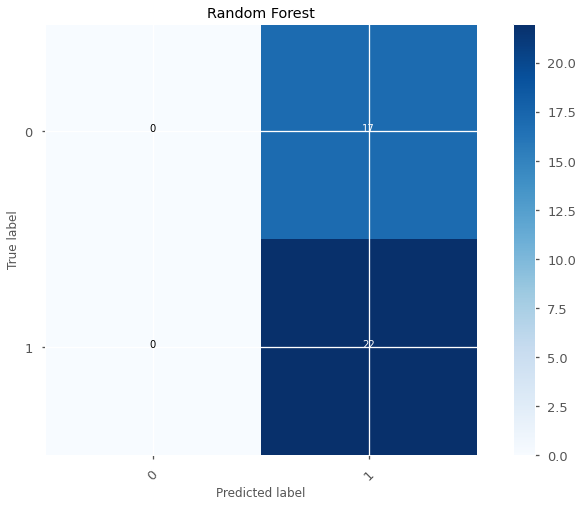

In [69]:
svm_bowl_14 = svm_14.predict(X_bowl_14)

svm_cm_14 = confusion_matrix(y_bowl_14,svm_bowl_14)
print(classification_report(y_bowl_14,svm_bowl_14))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_14,svm_bowl_14),2)))

plot_confusion_matrix(
    svm_cm_14,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.59      1.00      0.74        24

    accuracy                           0.59        41
   macro avg       0.29      0.50      0.37        41
weighted avg       0.34      0.59      0.43        41

This set of predictions was 58.54% accurate

Confusion matrix, without normalization
[[ 0 17]
 [ 0 24]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

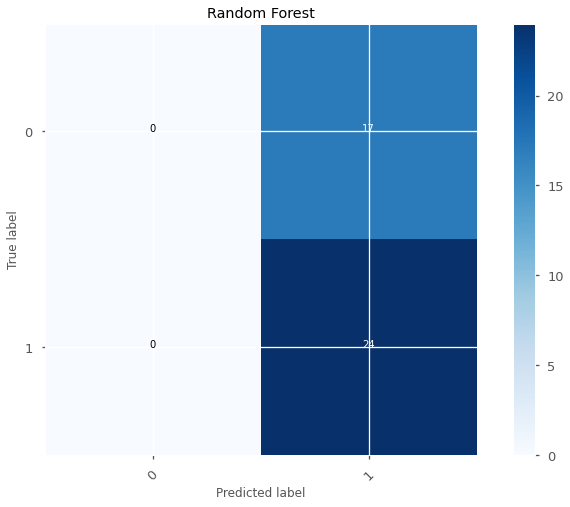

In [70]:
svm_bowl_15 = svm_15.predict(X_bowl_15)

svm_cm_15 = confusion_matrix(y_bowl_15,svm_bowl_15)
print(classification_report(y_bowl_15,svm_bowl_15))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_15,svm_bowl_15),2)))

plot_confusion_matrix(
    svm_cm_15,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.51      1.00      0.68        21

    accuracy                           0.51        41
   macro avg       0.26      0.50      0.34        41
weighted avg       0.26      0.51      0.35        41

This set of predictions was 51.22% accurate

Confusion matrix, without normalization
[[ 0 20]
 [ 0 21]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

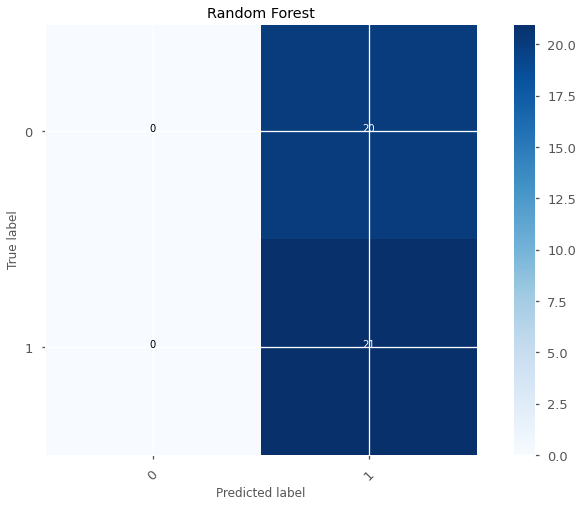

In [71]:
svm_bowl_16 = svm_16.predict(X_bowl_16)

svm_cm_16 = confusion_matrix(y_bowl_16,svm_bowl_16)
print(classification_report(y_bowl_16,svm_bowl_16))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_16,svm_bowl_16),2)))

plot_confusion_matrix(
    svm_cm_16,title='Random Forest', cmap=plt.cm.Blues)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.42      1.00      0.60        17

    accuracy                           0.42        40
   macro avg       0.21      0.50      0.30        40
weighted avg       0.18      0.42      0.25        40

This set of predictions was 42.5% accurate

Confusion matrix, without normalization
[[ 0 23]
 [ 0 17]]


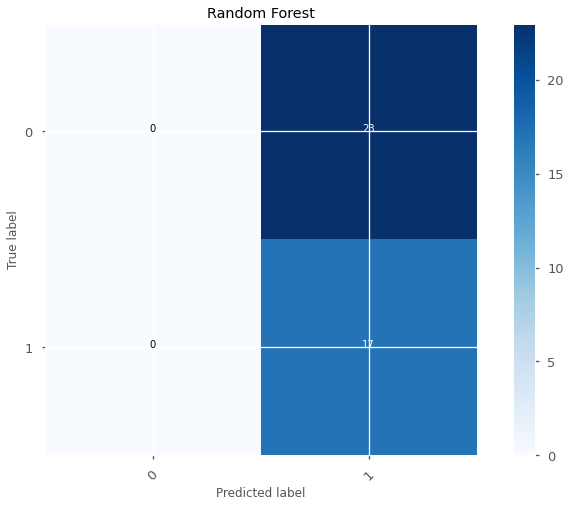

In [72]:
svm_bowl_17 = svm_17.predict(X_bowl_17)

svm_cm_17 = confusion_matrix(y_bowl_17,svm_bowl_17)
print(classification_report(y_bowl_17,svm_bowl_17))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_17,svm_bowl_17),2)))

plot_confusion_matrix(
    svm_cm_17,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.59      1.00      0.74        23

    accuracy                           0.59        39
   macro avg       0.29      0.50      0.37        39
weighted avg       0.35      0.59      0.44        39

This set of predictions was 58.97% accurate

Confusion matrix, without normalization
[[ 0 16]
 [ 0 23]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

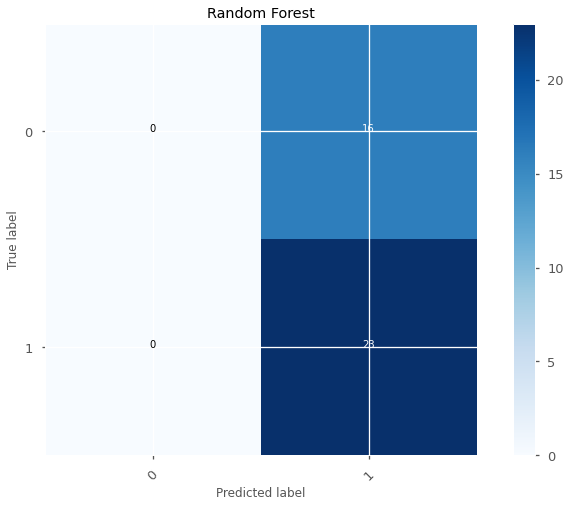

In [73]:
svm_bowl_18 = svm_18.predict(X_bowl_18)

svm_cm_18 = confusion_matrix(y_bowl_18,svm_bowl_18)
print(classification_report(y_bowl_18,svm_bowl_18))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_18,svm_bowl_18),2)))

plot_confusion_matrix(
    svm_cm_18,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.45      1.00      0.62        18

    accuracy                           0.45        40
   macro avg       0.23      0.50      0.31        40
weighted avg       0.20      0.45      0.28        40

This set of predictions was 45.0% accurate

Confusion matrix, without normalization
[[ 0 22]
 [ 0 18]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

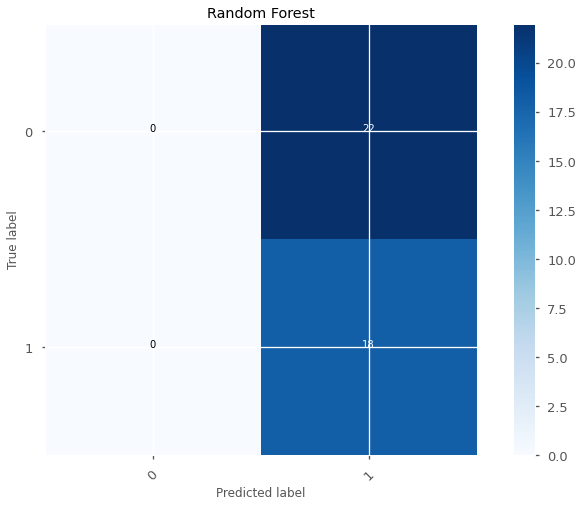

In [74]:
svm_bowl_19 = svm_19.predict(X_bowl_19)

svm_cm_19 = confusion_matrix(y_bowl_19,svm_bowl_19)
print(classification_report(y_bowl_19,svm_bowl_19))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_19,svm_bowl_19),2)))

plot_confusion_matrix(
    svm_cm_19,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.54      1.00      0.70        14

    accuracy                           0.54        26
   macro avg       0.27      0.50      0.35        26
weighted avg       0.29      0.54      0.38        26

This set of predictions was 53.85% accurate

Confusion matrix, without normalization
[[ 0 12]
 [ 0 14]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

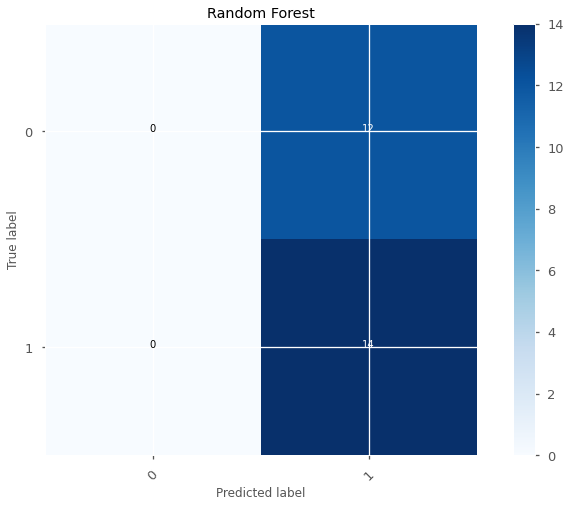

In [75]:
svm_bowl_20 = svm_20.predict(X_bowl_20)

svm_cm_20 = confusion_matrix(y_bowl_20,svm_bowl_20)
print(classification_report(y_bowl_20,svm_bowl_20))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_20,svm_bowl_20),2)))

plot_confusion_matrix(
    svm_cm_20,title='Random Forest', cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.53      1.00      0.69        20

    accuracy                           0.53        38
   macro avg       0.26      0.50      0.34        38
weighted avg       0.28      0.53      0.36        38

This set of predictions was 52.63% accurate

Confusion matrix, without normalization
[[ 0 18]
 [ 0 20]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sample

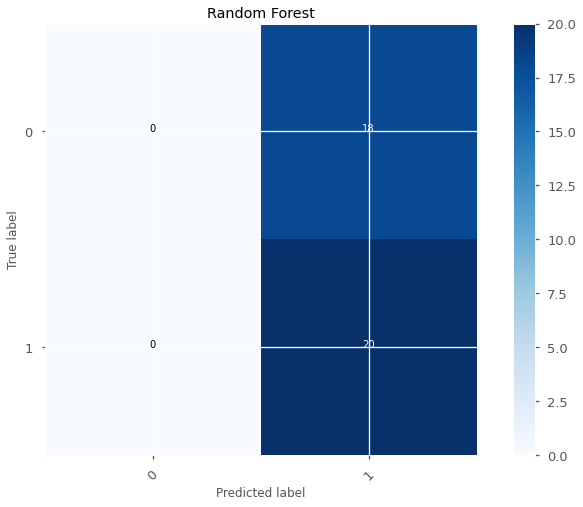

In [76]:
svm_bowl_21 = svm_21.predict(X_bowl_21)

svm_cm_21 = confusion_matrix(y_bowl_21,svm_bowl_21)
print(classification_report(y_bowl_21,svm_bowl_21))
print("This set of predictions was %s%% accurate\n" %str(
    round(100*accuracy_score(y_bowl_21,svm_bowl_21),2)))

plot_confusion_matrix(
    svm_cm_21,title='Random Forest', cmap=plt.cm.Blues)

In [77]:
svm_bowl_22 = svm_22.predict(X_bowl_22)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


# Get Correct Predictions from Bowls before 2022

### 2014

In [78]:
for bowl, home, away,year,actual in zip(svm_bowl_14, home_bowl_14, away_bowl_14,year_bowl_14,y_bowl_14):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2014, Louisiana vs Nevada, predicted winner Louisiana <br>
For 2014, Air Force vs Western Michigan, predicted winner Air Force <br>
For 2014, Bowling Green vs South Alabama, predicted winner Bowling Green <br>
For 2014, Memphis vs BYU, predicted winner Memphis <br>
For 2014, Western Kentucky vs Central Michigan, predicted winner Western Kentucky <br>
For 2014, Rice vs Fresno State, predicted winner Rice <br>
For 2014, Louisiana Tech vs Illinois, predicted winner Louisiana Tech <br>
For 2014, Virginia Tech vs Cincinnati, predicted winner Virginia Tech <br>
For 2014, South Carolina vs Miami, predicted winner South Carolina <br>
For 2014, Penn State vs Boston College, predicted winner Penn State <br>
For 2014, USC vs Nebraska, predicted winner USC <br>
For 2014, Clemson vs Oklahoma, predicted winner Clemson <br>
For 2014, Stanford vs Maryland, predicted winner Stanford <br>
For 2014, TCU vs Ole Miss, predicted winner TCU <br>
For 2014, Georgia Tech vs Mississippi State, predicted winn

### 2015

In [79]:
for bowl, home, away,year,actual in zip(svm_bowl_15, home_bowl_15, away_bowl_15,year_bowl_15,y_bowl_15):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2015, Utah vs BYU, predicted winner Utah <br>
For 2015, Appalachian State vs Ohio, predicted winner Appalachian State <br>
For 2015, Louisiana Tech vs Arkansas State, predicted winner Louisiana Tech <br>
For 2015, Toledo vs Temple, predicted winner Toledo <br>
For 2015, Western Michigan vs Middle Tennessee, predicted winner Western Michigan <br>
For 2015, Marshall vs Connecticut, predicted winner Marshall <br>
For 2015, Washington State vs Miami, predicted winner Washington State <br>
For 2015, Duke vs Indiana, predicted winner Duke <br>
For 2015, Virginia Tech vs Tulsa, predicted winner Virginia Tech <br>
For 2015, Nebraska vs UCLA, predicted winner Nebraska <br>
For 2015, Navy vs Pittsburgh, predicted winner Navy <br>
For 2015, Minnesota vs Central Michigan, predicted winner Minnesota <br>
For 2015, Baylor vs North Carolina, predicted winner Baylor <br>
For 2015, Mississippi State vs NC State, predicted winner Mississippi State <br>
For 2015, Louisville vs Texas A&M, predicted wi

### 2016

In [80]:
for bowl, home, away,year,actual in zip(svm_bowl_16, home_bowl_16, away_bowl_16,year_bowl_16,y_bowl_16):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2016, San Diego State vs Houston, predicted winner San Diego State <br>
For 2016, Tulsa vs Central Michigan, predicted winner Tulsa <br>
For 2016, Western Kentucky vs Memphis, predicted winner Western Kentucky <br>
For 2016, Old Dominion vs Eastern Michigan, predicted winner Old Dominion <br>
For 2016, Troy vs Ohio, predicted winner Troy <br>
For 2016, Mississippi State vs Miami (OH), predicted winner Mississippi State <br>
For 2016, Boston College vs Maryland, predicted winner Boston College <br>
For 2016, Wake Forest vs Temple, predicted winner Wake Forest <br>
For 2016, Baylor vs Boise State, predicted winner Baylor <br>
For 2016, Northwestern vs Pittsburgh, predicted winner Northwestern <br>
For 2016, Miami vs West Virginia, predicted winner Miami <br>
For 2016, Utah vs Indiana, predicted winner Utah <br>
For 2016, Kansas State vs Texas A&M, predicted winner Kansas State <br>
For 2016, Virginia Tech vs Arkansas, predicted winner Virginia Tech <br>
For 2016, Tennessee vs Nebrask

### 2017

In [81]:
for bowl, home, away,year,actual in zip(svm_bowl_14, home_bowl_17, away_bowl_17,year_bowl_17,y_bowl_17):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2017, Georgia State vs Western Kentucky, predicted winner Georgia State <br>
For 2017, Florida Atlantic vs Akron, predicted winner Florida Atlantic <br>
For 2017, Ohio vs UAB, predicted winner Ohio <br>
For 2017, Wyoming vs Central Michigan, predicted winner Wyoming <br>
For 2017, South Florida vs Texas Tech, predicted winner South Florida <br>
For 2017, Army vs San Diego State, predicted winner Army <br>
For 2017, Florida State vs Southern Mississippi, predicted winner Florida State <br>
For 2017, Purdue vs Arizona, predicted winner Purdue <br>
For 2017, Navy vs Virginia, predicted winner Navy <br>
For 2017, Oklahoma State vs Virginia Tech, predicted winner Oklahoma State <br>
For 2017, Michigan State vs Washington State, predicted winner Michigan State <br>
For 2017, TCU vs Stanford, predicted winner TCU <br>
For 2017, Northwestern vs Kentucky, predicted winner Northwestern <br>
For 2017, Ohio State vs USC, predicted winner Ohio State <br>
For 2017, Mississippi State vs Louisvill

### 2018

In [82]:
for bowl, home, away,year,actual in zip(svm_bowl_18, home_bowl_18, away_bowl_18,year_bowl_18,y_bowl_18):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2018, Fresno State vs Arizona State, predicted winner Fresno State <br>
For 2018, Appalachian State vs Middle Tennessee, predicted winner Appalachian State <br>
For 2018, Ohio vs San Diego State, predicted winner Ohio <br>
For 2018, BYU vs Western Michigan, predicted winner BYU <br>
For 2018, Wake Forest vs Memphis, predicted winner Wake Forest <br>
For 2018, Army vs Houston, predicted winner Army <br>
For 2018, Troy vs Buffalo, predicted winner Troy <br>
For 2018, Louisiana Tech vs Hawai'i, predicted winner Louisiana Tech <br>
For 2018, TCU vs California, predicted winner TCU <br>
For 2018, Duke vs Temple, predicted winner Duke <br>
For 2018, Wisconsin vs Miami, predicted winner Wisconsin <br>
For 2018, Auburn vs Purdue, predicted winner Auburn <br>
For 2018, Syracuse vs West Virginia, predicted winner Syracuse <br>
For 2018, Washington State vs Iowa State, predicted winner Washington State <br>
For 2018, Virginia vs South Carolina, predicted winner Virginia <br>
For 2018, Nevada 

### 2019

In [83]:
for bowl, home, away,year,actual in zip(svm_bowl_19, home_bowl_19, away_bowl_19,year_bowl_19,y_bowl_19):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2019, Kent State vs Utah State, predicted winner Kent State <br>
For 2019, San Diego State vs Central Michigan, predicted winner San Diego State <br>
For 2019, Florida Atlantic vs SMU, predicted winner Florida Atlantic <br>
For 2019, Arkansas State vs Florida International, predicted winner Arkansas State <br>
For 2019, Washington vs Boise State, predicted winner Washington <br>
For 2019, Texas A&M vs Oklahoma State, predicted winner Texas A&M <br>
For 2019, Iowa vs USC, predicted winner Iowa <br>
For 2019, Penn State vs Memphis, predicted winner Penn State <br>
For 2019, LSU vs Oklahoma, predicted winner LSU <br>
For 2019, Louisville vs Mississippi State, predicted winner Louisville <br>
For 2019, Kentucky vs Virginia Tech, predicted winner Kentucky <br>
For 2019, Arizona State vs Florida State, predicted winner Arizona State <br>
For 2019, Texas vs Utah, predicted winner Texas <br>
For 2019, Alabama vs Michigan, predicted winner Alabama <br>
For 2019, Cincinnati vs Boston College

### 2020

In [84]:
for bowl, home, away,year,actual in zip(svm_bowl_20, home_bowl_20, away_bowl_20,year_bowl_20,y_bowl_20):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2020, Nevada vs Tulane, predicted winner Nevada <br>
For 2020, BYU vs UCF, predicted winner BYU <br>
For 2020, Georgia Southern vs Louisiana Tech, predicted winner Georgia Southern <br>
For 2020, Buffalo vs Marshall, predicted winner Buffalo <br>
For 2020, Georgia State vs Western Kentucky, predicted winner Georgia State <br>
For 2020, Wisconsin vs Wake Forest, predicted winner Wisconsin <br>
For 2020, Oklahoma vs Florida, predicted winner Oklahoma <br>
For 2020, Mississippi State vs Tulsa, predicted winner Mississippi State <br>
For 2020, Georgia vs Cincinnati, predicted winner Georgia <br>
For 2020, Northwestern vs Auburn, predicted winner Northwestern <br>
For 2020, Alabama vs Notre Dame, predicted winner Alabama <br>
For 2020, Kentucky vs NC State, predicted winner Kentucky <br>
For 2020, Iowa State vs Oregon, predicted winner Iowa State <br>
For 2020, Alabama vs Ohio State, predicted winner Alabama <br>


### 2021

In [85]:
for bowl, home, away,year,actual in zip(svm_bowl_21, home_bowl_21, away_bowl_21,year_bowl_21,y_bowl_21):
    year = str(year)
    if actual == bowl:
        if bowl == 1:
            predicted_winner = home
        else:
            predicted_winner = away
        print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2021, Coastal Carolina vs Northern Illinois, predicted winner Coastal Carolina <br>
For 2021, Fresno State vs UTEP, predicted winner Fresno State <br>
For 2021, Liberty vs Eastern Michigan, predicted winner Liberty <br>
For 2021, Tulsa vs Old Dominion, predicted winner Tulsa <br>
For 2021, Wyoming vs Kent State, predicted winner Wyoming <br>
For 2021, San Diego State vs UT San Antonio, predicted winner San Diego State <br>
For 2021, Army vs Missouri, predicted winner Army <br>
For 2021, Miami (OH) vs North Texas, predicted winner Miami (OH) <br>
For 2021, Texas Tech vs Mississippi State, predicted winner Texas Tech <br>
For 2021, Minnesota vs West Virginia, predicted winner Minnesota <br>
For 2021, Oklahoma vs Oregon, predicted winner Oklahoma <br>
For 2021, South Carolina vs North Carolina, predicted winner South Carolina <br>
For 2021, Purdue vs Tennessee, predicted winner Purdue <br>
For 2021, Michigan State vs Pittsburgh, predicted winner Michigan State <br>
For 2021, Central M

### 2022

In [86]:
for bowl, home, away,year in zip(svm_bowl_22, home_bowl_22, away_bowl_22,year_bowl_22):
    year = str(year)
    if bowl == 1:
        predicted_winner = home
    else:
        predicted_winner = away
    print("For %s, %s vs %s, predicted winner %s <br>" % (year, home, away, predicted_winner))

For 2022, TCU vs Michigan, predicted winner TCU <br>
For 2022, Georgia vs Ohio State, predicted winner Georgia <br>
For 2022, Kansas State vs Alabama, predicted winner Kansas State <br>
For 2022, Clemson vs Tennessee, predicted winner Clemson <br>
For 2022, Texas vs Washington, predicted winner Texas <br>
For 2022, Oklahoma vs Florida State, predicted winner Oklahoma <br>
For 2022, Georgia vs Michigan, predicted winner Georgia <br>
